In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import importlib

import warnings
warnings.filterwarnings("ignore")

import pca_dax.data_handler as dh

# Data Gathering and Preprocessing

In [2]:
# Initialise a data handler class instance
# It checks for DAX constituents in database or on web if none are found
# Then fetches the data (either from DB or Yahoo! Finance API)
# For constituents for the specified time period
data_instance = dh.DataHandler(
    index='DAX'
    , start_date='2010-01-01'
    , end_date='2023-08-01'
)

# Fetches raw data from the database in wide format, i.e. stocks as columns 
dax_data = data_instance.fetch_stocks_from_db(
    price_type='adj_close'
    , wide_format=True
)

dax_data.head()

,1COV.DE,1U1.DE,8TRA.DE,AAD.DE,ADJ.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,...,VNA.DE,VOS.DE,VOW3.DE,WAC.DE,WAF.DE,WCH.DE,WSU.DE,WUW.DE,ZAL.DE,ZO1.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,2.997455,NaN,9.118773,NaN,31.464582,2.525,10.414361,11.362466,21.803215,...,NaN,51.389050,37.498192,5.975751,NaN,81.023949,4.757605,9.949111,NaN,15.952764
2010-01-05,NaN,2.973282,NaN,9.430388,NaN,32.457432,2.670,10.680754,11.281304,21.880951,...,NaN,51.733070,36.771477,5.984904,NaN,81.624619,4.684784,9.973813,NaN,15.670896
2010-01-06,NaN,2.888676,NaN,9.408520,NaN,32.195934,2.810,10.722379,11.358408,22.772655,...,NaN,51.776981,37.788872,6.083480,NaN,83.026184,4.684784,10.128205,NaN,15.960182
2010-01-07,NaN,2.804071,NaN,9.430388,NaN,32.477859,2.650,10.722379,11.455798,22.946423,...,NaN,51.652546,38.224899,6.139808,NaN,81.090683,4.854699,10.066450,NaN,15.824193
2010-01-08,NaN,2.761768,NaN,9.567060,NaN,32.359364,2.720,10.722379,11.642469,22.786373,...,NaN,53.299393,38.637672,6.090520,NaN,80.323158,4.794016,10.189963,NaN,15.576940


In [3]:
print(len(dax_data))

3451


In [4]:
dax_data_clean = dax_data.dropna(
    axis=1
    , thresh=int(0.99*len(dax_data))
)

dax_data_clean.isna().sum()

1U1.DE     4
AAD.DE     4
ADS.DE     4
ADV.DE     4
AFX.DE     4
          ..
VOW3.DE    4
WAC.DE     4
WCH.DE     4
WSU.DE     4
WUW.DE     4
Length: 108, dtype: int64

In [5]:
# missing values have some systematic nature
# dax_data_clean[dax_data_clean.isnull().any(axis=1)]

In [6]:
# Preprocess the data: drop the stocks that have more than 1% of missing data
# Forward fill the rest 
dax_data = data_instance.preprocess()

# The number of stocks shrinks to 108 from 146
dax_data.head()

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2.997455,9.118773,31.464582,2.525,10.414361,11.362466,21.803215,45.519119,4.128044,22.398512,...,24.003975,4.423787,7.499338,2.908911,51.389050,37.498192,5.975751,81.023949,4.757605,9.949111
2010-01-05,2.973282,9.430388,32.457432,2.670,10.680754,11.281304,21.880951,45.657925,4.204177,22.058916,...,24.328173,4.479009,7.859563,3.067579,51.733070,36.771477,5.984904,81.624619,4.684784,9.973813
2010-01-06,2.888676,9.408520,32.195934,2.810,10.722379,11.358408,22.772655,46.012665,4.270158,22.198751,...,24.209881,4.617673,7.893831,3.094023,51.776981,37.788872,6.083480,83.026184,4.684784,10.128205
2010-01-07,2.804071,9.430388,32.477859,2.650,10.722379,11.455798,22.946423,45.483139,4.207561,22.051426,...,24.139786,4.509686,7.691406,3.094905,51.652546,38.224899,6.139808,81.090683,4.854699,10.066450
2010-01-08,2.761768,9.567060,32.359364,2.720,10.722379,11.642469,22.786373,45.236362,4.161881,21.984007,...,24.595419,4.479009,7.834059,3.243876,53.299393,38.637672,6.090520,80.323158,4.794016,10.189963


In [7]:
# All missing values were filled
# dax_data.isna().sum()

In [8]:
# Create daily price changes from the preprocessed data
rts = data_instance.create_daily_change()

rts.head()

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.008065,0.034173,0.031555,0.057426,0.025579,-0.007143,0.003565,0.003049,0.018443,-0.015162,...,0.013506,0.012483,0.048034,0.054546,0.006694,-0.019380,0.001532,0.007413,-0.015306,0.002483
2010-01-06,-0.028455,-0.002319,-0.008057,0.052434,0.003897,0.006835,0.040753,0.007770,0.015694,0.006339,...,-0.004862,0.030959,0.004360,0.008621,0.000849,0.027668,0.016471,0.017171,0.000000,0.015480
2010-01-07,-0.029289,0.002324,0.008757,-0.056939,0.000000,0.008574,0.007631,-0.011508,-0.014659,-0.006637,...,-0.002895,-0.023386,-0.025644,0.000285,-0.002403,0.011539,0.009259,-0.023312,0.036269,-0.006097
2010-01-08,-0.015086,0.014493,-0.003649,0.026415,0.000000,0.016295,-0.006975,-0.005426,-0.010857,-0.003057,...,0.018875,-0.006803,0.018547,0.048134,0.031883,0.010799,-0.008028,-0.009465,-0.012500,0.012270
2010-01-11,0.019694,-0.014286,0.006313,0.018015,0.007764,0.008017,-0.042545,-0.011251,0.006098,-0.011131,...,-0.023869,0.004110,0.007630,0.073370,0.005081,0.007373,0.017341,-0.002493,0.018987,0.017576


In [9]:
# Fetch the data about the companies from DB, retain only sectors
sectors_df = data_instance.fetch_info_from_db()[['symbol', 'industry', 'sector']]

sectors_df.head()

,symbol,industry,sector
0,1COV.DE,Specialty Chemicals,Basic Materials
1,1U1.DE,Telecom Services,Communication Services
2,8TRA.DE,Farm & Heavy Construction Machinery,Industrials
3,AAD.DE,Staffing & Employment Services,Industrials
4,ADJ.DE,Real Estate Services,Real Estate


In [10]:
sectors_df.sector.unique().tolist()

['Basic Materials',
 'Communication Services',
 'Industrials',
 'Real Estate',
 'Consumer Cyclical',
 'Technology',
 'Healthcare',
 'Financial Services',
 'Consumer Defensive',
 '',
 'Utilities']

# Modelling and EDA

## Central moments examination

In [11]:
# Vector of means of each of R_t
rts.mean()

1U1.DE     0.000620
AAD.DE     0.000911
ADS.DE     0.000688
ADV.DE     0.000976
AFX.DE     0.000830
             ...   
VOW3.DE    0.000577
WAC.DE     0.000670
WCH.DE     0.000452
WSU.DE     0.000782
WUW.DE     0.000242
Length: 108, dtype: float64

In [12]:
# Standard deviations of R_t
rts.std()

1U1.DE     0.022354
AAD.DE     0.020140
ADS.DE     0.018913
ADV.DE     0.027367
AFX.DE     0.018151
             ...   
VOW3.DE    0.021856
WAC.DE     0.023357
WCH.DE     0.024235
WSU.DE     0.020433
WUW.DE     0.014789
Length: 108, dtype: float64

Mean-Volatility Plot to see how the equities are placed against each other

In [13]:
# Calculates mean and standard deviations of return series and combines them in one table (with sectors)
mean_var_df = data_instance.create_mean_var_df()

mean_var_df.head()

,symbol,mean,vol,sector
0,1U1.DE,0.000620,0.022354,Communication Services
1,AAD.DE,0.000911,0.020140,Industrials
2,ADS.DE,0.000688,0.018913,Consumer Cyclical
3,ADV.DE,0.000976,0.027367,Technology
4,AFX.DE,0.000830,0.018151,Healthcare


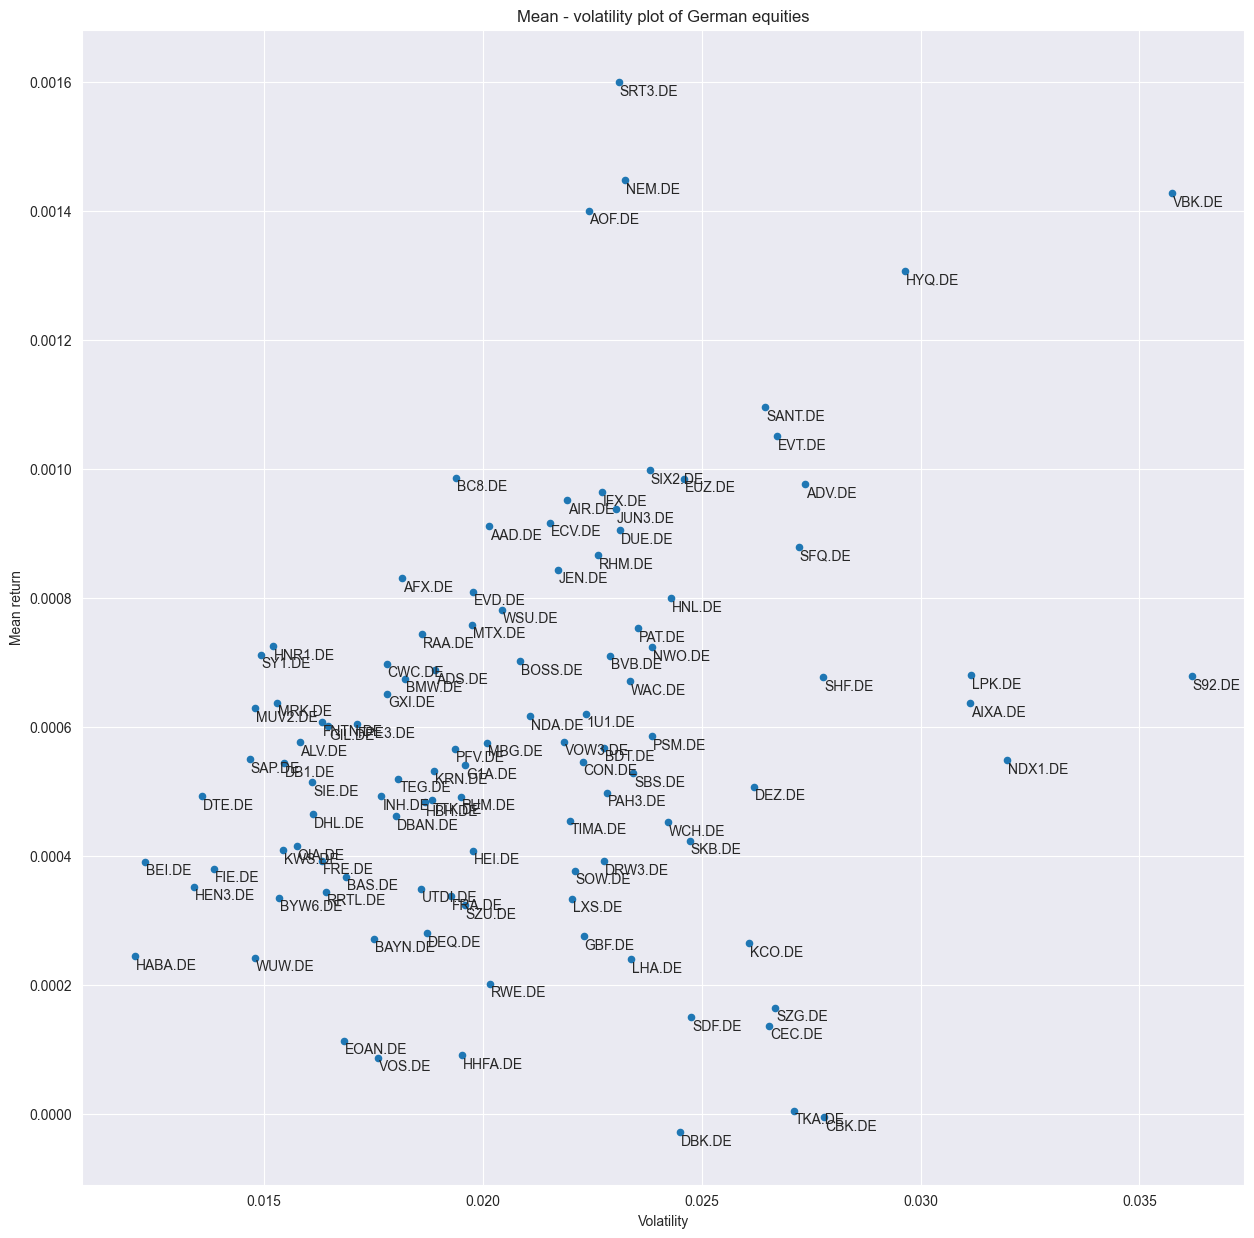

In [14]:
g = mean_var_df.plot(
    kind='scatter'
    , x='vol'
    , y='mean'
    , figsize=(15, 15)
)

for ticker in mean_var_df.symbol:
    plt.annotate(
        ticker
        , xy=(
            mean_var_df[mean_var_df.symbol == ticker]['vol'] + 0.00002
            , mean_var_df[mean_var_df.symbol == ticker]['mean'] - 0.00002
        )
    )

g.set(xlabel='Volatility', ylabel='Mean return', title='Mean - volatility plot of German equities')

plt.show();

In [15]:
# Skewness
rts.skew()

1U1.DE    -2.729354
AAD.DE     0.082338
ADS.DE     0.486091
ADV.DE    -0.067668
AFX.DE     0.026872
             ...   
VOW3.DE   -0.178929
WAC.DE     0.013010
WCH.DE     0.038899
WSU.DE     0.222104
WUW.DE    -0.012608
Length: 108, dtype: float64

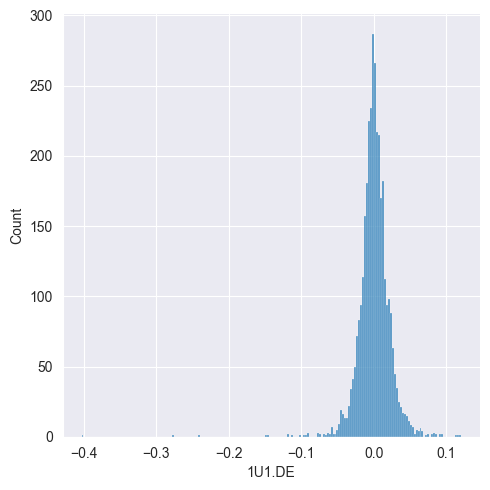

In [16]:
sns.displot(
    rts
    , x='1U1.DE'
    # , kind='kde'
);

In [17]:
rts[rts['1U1.DE'] == rts['1U1.DE'].min()]['1U1.DE']

date
2011-11-07   -0.403341
Name: 1U1.DE, dtype: float64

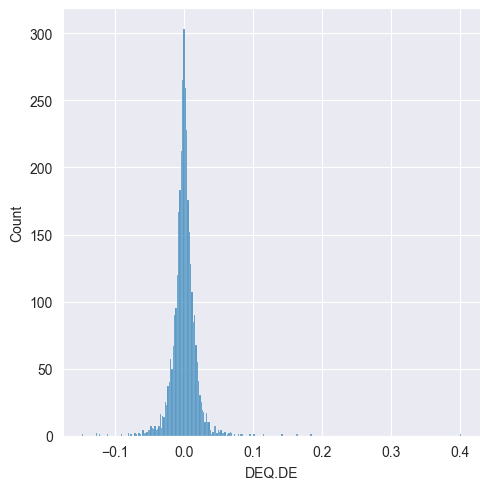

In [18]:
# High skewness example
sns.displot(
    rts
    , x='DEQ.DE'
    # , kind='kde'
);

In [19]:
rts[rts['DEQ.DE'] == rts['DEQ.DE'].max()]['DEQ.DE']

date
2022-05-23    0.401152
Name: DEQ.DE, dtype: float64

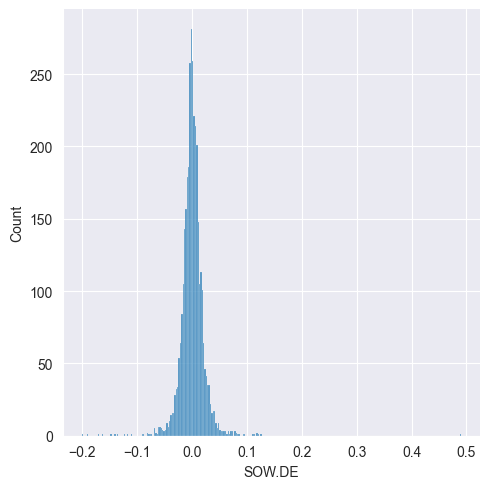

In [20]:
sns.displot(
    rts
    , x='SOW.DE'
    # , kind='kde'
);

In [21]:
# Unbiased kurtosis
rts.kurt() 

1U1.DE     44.689665
AAD.DE      4.258998
ADS.DE     10.261359
ADV.DE      6.993297
AFX.DE      3.727355
             ...    
VOW3.DE     8.339310
WAC.DE      3.347524
WCH.DE      2.794211
WSU.DE      5.212788
WUW.DE      9.460308
Length: 108, dtype: float64

### Jarque-Bera test

In [22]:
rts.apply(lambda t: stats.jarque_bera(t), axis=0)

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
0,290518.784174,2601.710241,15223.026718,7009.051752,1989.916762,20090.742693,19132.779633,17054.771259,2486.760097,2148.217308,...,14236.364897,4097.719108,35169.235919,6079.099747,6334.969495,9982.249946,1604.613574,1.118570e+03,3920.57123,12823.37706
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.275112e-243,0.00000,0.00000


## Durbin-Watson test for autocorrelation

In [23]:
from statsmodels.stats.stattools import durbin_watson

def dw_test(ts: pd.DataFrame) -> pd.DataFrame:
    dw_output = pd.DataFrame(index=ts.columns.to_list())
    
    for ticker in ts.columns:
        dw_output.loc[ticker, 'Durbin-Watson Statistic'] = durbin_watson(ts[ticker])
    
    return dw_output

In [24]:
dw_test(rts)

,Durbin-Watson Statistic
1U1.DE,2.024550
AAD.DE,1.997700
ADS.DE,1.951025
ADV.DE,2.085690
AFX.DE,2.011969
...,...
VOW3.DE,1.830126
WAC.DE,2.011490
WCH.DE,1.894188
WSU.DE,2.150534


Most of the stocks are within 1.8 - 2.2 range of DW statistics, which implies no presence of autocorrelation.

## ADF Test for weakly stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller

# Test the returns for weakly stationarity
# H_0: the time series is not stationary
# H_1: is stationary
def adf_test(ts: pd.DataFrame) -> pd.DataFrame:
    adf_output = pd.DataFrame(
        index=[
            'Test statistic'
            , 'p-value'
            , '# Lags used'
            , 'Number of observations used'
        ]
    )

    for ticker in ts.columns:
        test_result = adfuller(ts[ticker])
        adf_output[ticker] = pd.Series(test_result[0:4], index=adf_output.index)

    return adf_output

As you can see, all returns are stationary

In [26]:
adf_test(rts).T

,Test statistic,p-value,# Lags used,Number of observations used
1U1.DE,-59.485303,0.000000e+00,0.0,3449.0
AAD.DE,-40.353343,0.000000e+00,1.0,3448.0
ADS.DE,-16.023952,6.160780e-29,13.0,3436.0
ADV.DE,-29.599144,0.000000e+00,3.0,3446.0
AFX.DE,-14.118598,2.447504e-26,22.0,3427.0
...,...,...,...,...
VOW3.DE,-21.680519,0.000000e+00,7.0,3442.0
WAC.DE,-43.115296,0.000000e+00,1.0,3448.0
WCH.DE,-20.804919,0.000000e+00,6.0,3443.0
WSU.DE,-18.785916,2.023841e-30,9.0,3440.0


### Ljung-Box test for autocorrelation

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljb_test(ts: pd.DataFrame) -> pd.DataFrame:
    ljb_output = pd.DataFrame(index=ts.columns.to_list())
    
    for ticker in ts.columns.to_list():
        # tests whether all lags are distributed independently
        ljb_output.loc[ticker, 'Ljung-Box result'] = (acorr_ljungbox(rts[ticker], lags=8).iloc[:, 1] > 0.05).all()
    
    return ljb_output

In [28]:
ljb_test(rts)['Ljung-Box result'].value_counts()

Ljung-Box result
False    73
True     35
Name: count, dtype: int64

## Correlation matrix

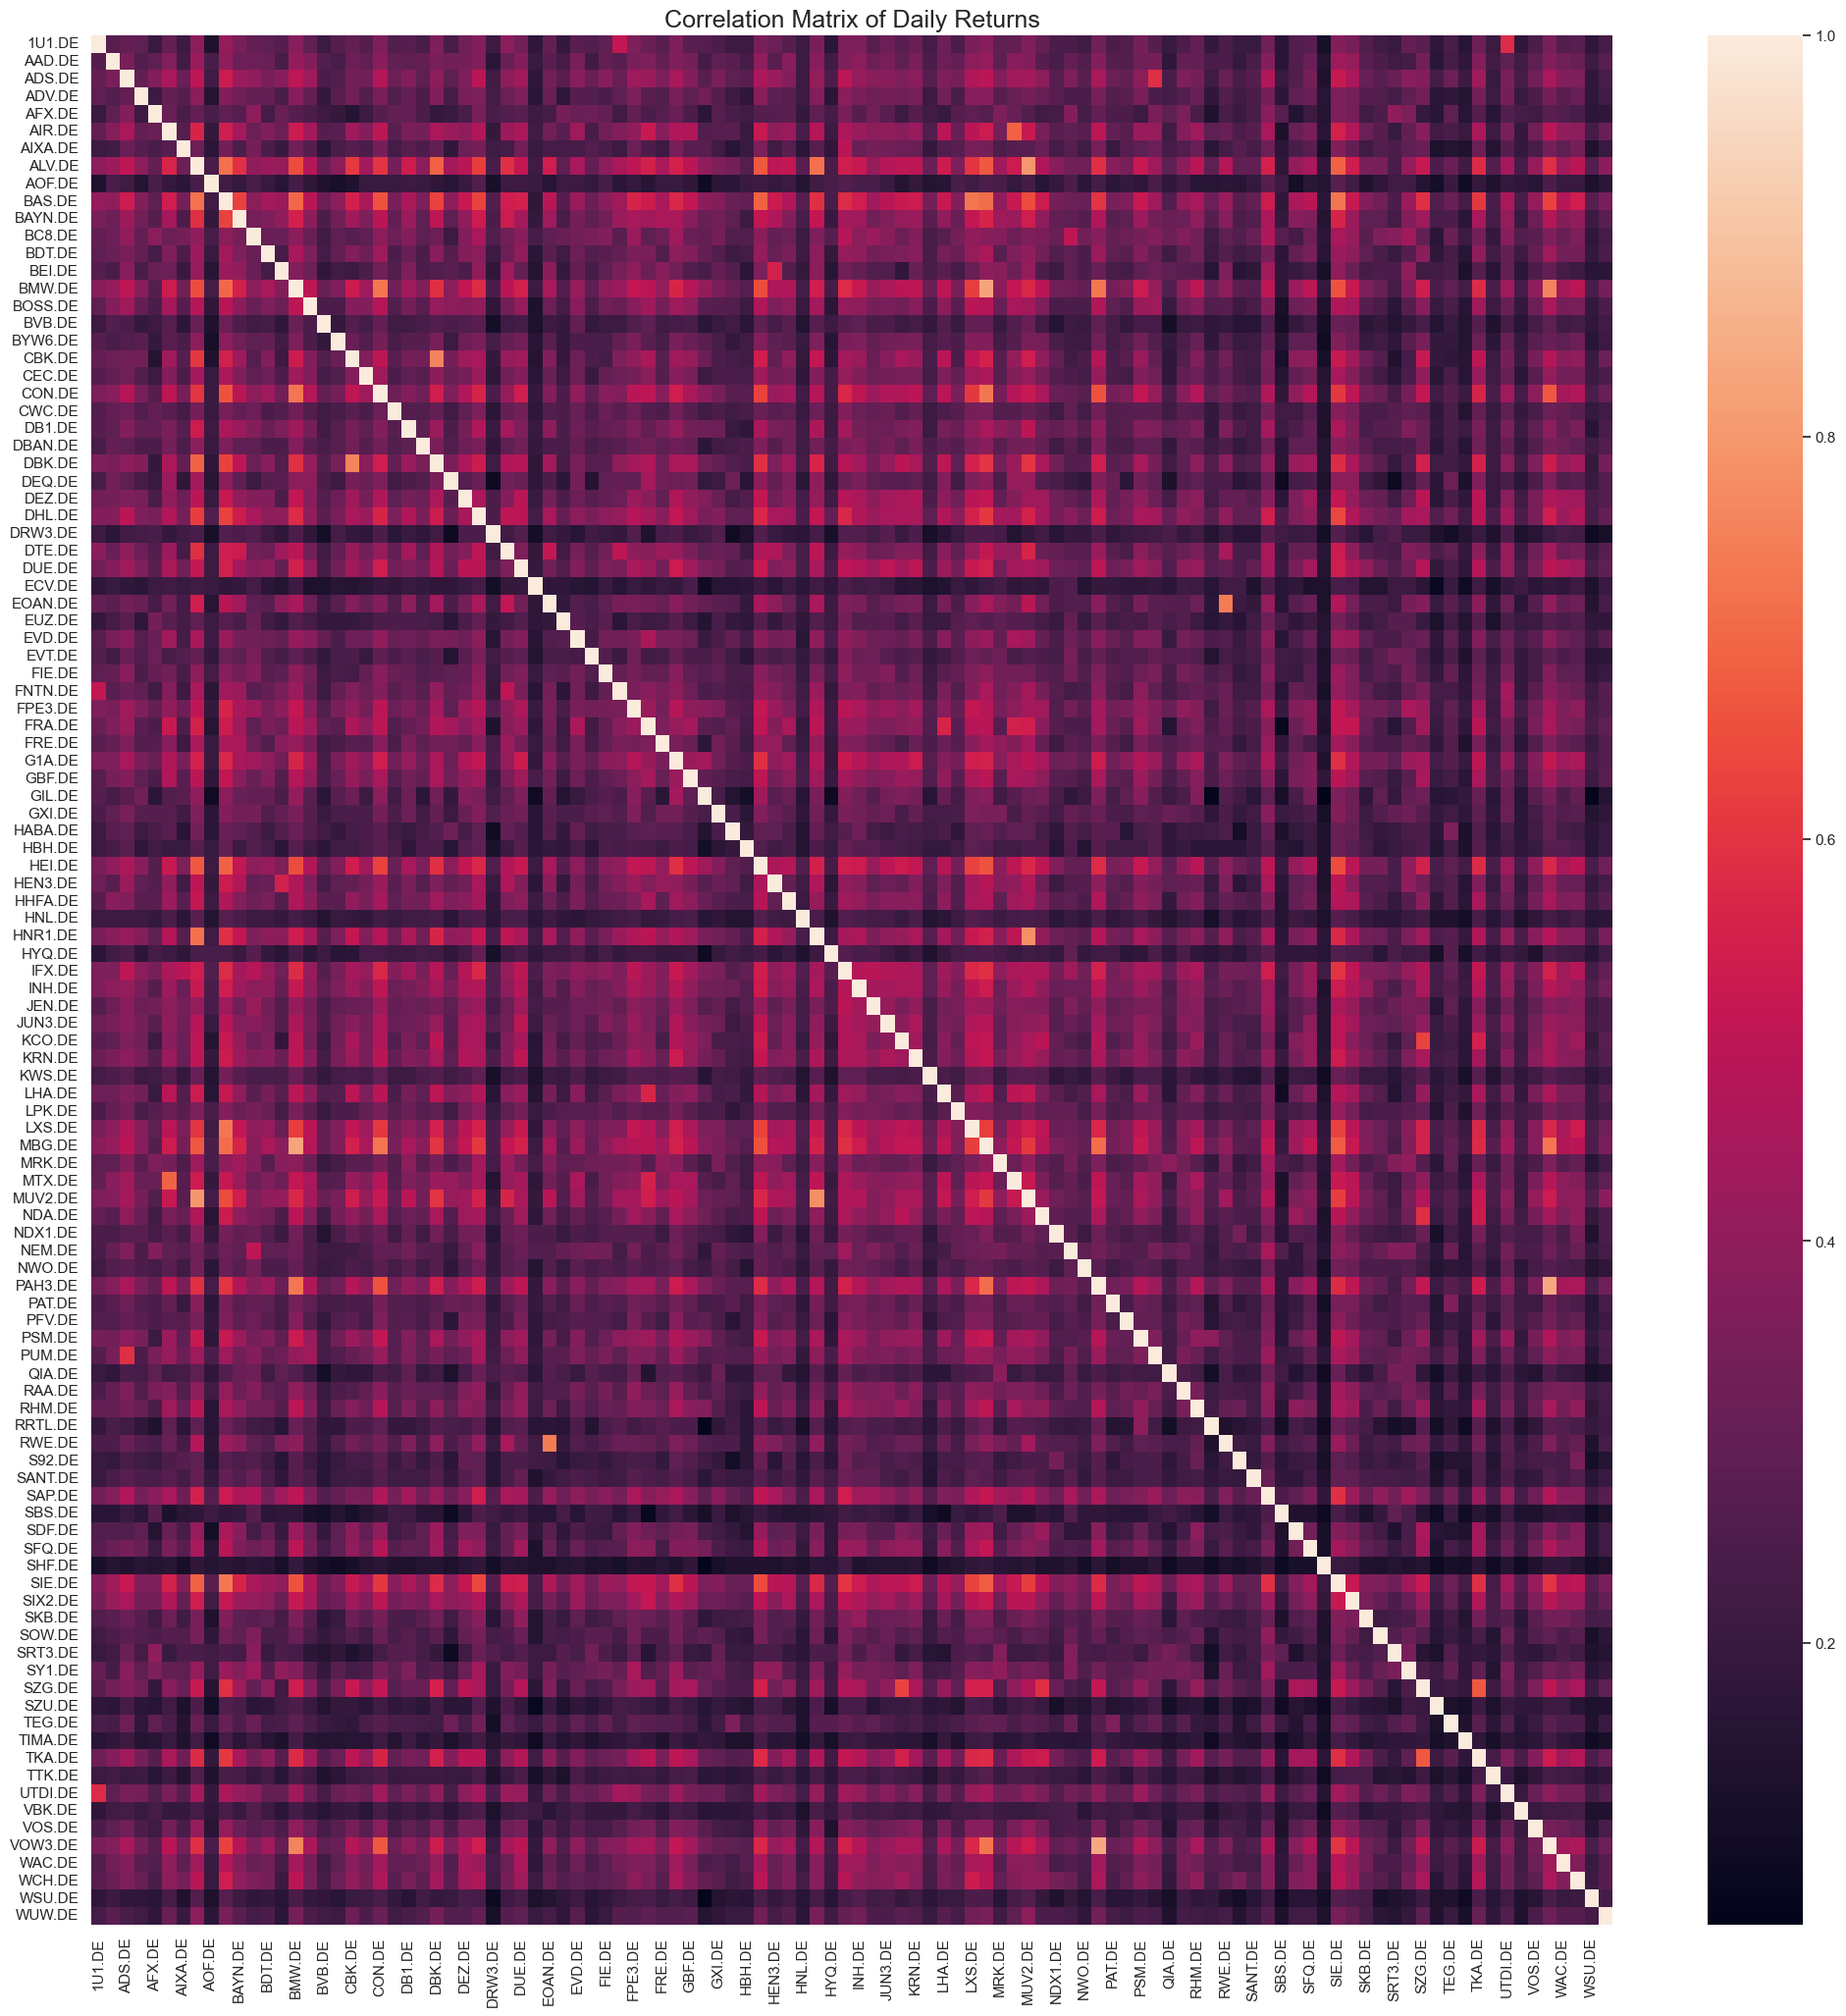

In [29]:
corr_matrix = rts.corr().round(decimals=2)

sns.set(rc={'figure.figsize':(25, 25)})
sns.heatmap(corr_matrix, annot=False)
plt.title(
    'Correlation Matrix of Daily Returns'
    , fontsize=18
)

plt.show();

In [30]:
corr_matrix

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
1U1.DE,1.00,0.27,0.30,0.29,0.20,0.30,0.21,0.39,0.14,0.41,...,0.32,0.21,0.58,0.18,0.25,0.35,0.26,0.28,0.18,0.23
AAD.DE,0.27,1.00,0.35,0.26,0.29,0.37,0.22,0.42,0.24,0.40,...,0.37,0.22,0.29,0.22,0.29,0.37,0.33,0.31,0.21,0.28
ADS.DE,0.30,0.35,1.00,0.30,0.37,0.45,0.31,0.50,0.22,0.53,...,0.43,0.20,0.35,0.23,0.33,0.45,0.37,0.36,0.18,0.24
ADV.DE,0.29,0.26,0.30,1.00,0.21,0.30,0.27,0.39,0.15,0.37,...,0.34,0.21,0.34,0.20,0.25,0.34,0.28,0.31,0.18,0.22
AFX.DE,0.20,0.29,0.37,0.21,1.00,0.31,0.24,0.30,0.24,0.29,...,0.27,0.16,0.26,0.23,0.22,0.28,0.26,0.24,0.17,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOW3.DE,0.35,0.37,0.45,0.34,0.28,0.49,0.34,0.59,0.25,0.63,...,0.53,0.23,0.39,0.22,0.34,1.00,0.43,0.46,0.24,0.32
WAC.DE,0.26,0.33,0.37,0.28,0.26,0.40,0.29,0.43,0.20,0.48,...,0.43,0.22,0.34,0.22,0.32,0.43,1.00,0.37,0.20,0.27
WCH.DE,0.28,0.31,0.36,0.31,0.24,0.39,0.34,0.49,0.20,0.54,...,0.48,0.21,0.34,0.23,0.29,0.46,0.37,1.00,0.21,0.27
WSU.DE,0.18,0.21,0.18,0.18,0.17,0.23,0.14,0.26,0.13,0.27,...,0.25,0.16,0.22,0.14,0.16,0.24,0.20,0.21,1.00,0.23


In [31]:
print(np.mean(np.mean(corr_matrix[corr_matrix != 1], axis=1)))

0.3020387677397024


In [32]:
np.mean(corr_matrix[corr_matrix != 1], axis=1).sort_values(ascending=False)[:10]

BAS.DE    0.437570
SIE.DE    0.436355
ALV.DE    0.436262
MBG.DE    0.428598
BMW.DE    0.423084
HEI.DE    0.415514
LXS.DE    0.404112
DHL.DE    0.402991
IFX.DE    0.401215
CON.DE    0.400654
dtype: float64

In [33]:
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

corr_pairs[corr_pairs != 1][:10]

VOW3.DE  PAH3.DE    0.84
PAH3.DE  VOW3.DE    0.84
MBG.DE   BMW.DE     0.83
BMW.DE   MBG.DE     0.83
ALV.DE   MUV2.DE    0.80
MUV2.DE  ALV.DE     0.80
         HNR1.DE    0.78
HNR1.DE  MUV2.DE    0.78
VOW3.DE  BMW.DE     0.76
DBK.DE   CBK.DE     0.76
dtype: float64

## Correlation by industry

In [34]:
for industry in sectors_df.industry.unique().tolist():
    df = rts[(rts # The returns
                 .columns 
                 .intersection( # where the stocks come from a particular industry
                    sectors_df.symbol[sectors_df.industry == industry].tolist()
                )
            )]

    if df.shape[1] > 1: # Only if the dataset contains more than 1 stock
        avg = np.mean( # Calculate the average
            np.mean( # of averages
                df.corr()
                , axis=1
            )
        ).round(3)
    
        print(f'Average correlation in {industry}: {avg}')


Average correlation in Specialty Chemicals: 0.479
Average correlation in Telecom Services: 0.604
Average correlation in Real Estate Services: 0.553
Average correlation in Footwear & Accessories: 0.797
Average correlation in Medical Instruments & Supplies: 0.475
Average correlation in Aerospace & Defense: 0.685
Average correlation in Software - Application: 0.551
Average correlation in Information Technology Services: 0.587
Average correlation in Auto Parts: 0.614
Average correlation in Household & Personal Products: 0.773
Average correlation in Auto Manufacturers: 0.823
Average correlation in Entertainment: 0.649
Average correlation in Conglomerates: 0.68
Average correlation in Banks - Regional: 0.878
Average correlation in Specialty Industrial Machinery: 0.405
Average correlation in Drug Manufacturers - Specialty & Generic: 0.658
Average correlation in Medical Devices: 0.476
Average correlation in Utilities - Diversified: 0.868
Average correlation in Insurance - Reinsurance: 0.891
Ave

In [35]:
rts.shape

(3450, 108)

In [36]:
np.log(rts.shape[0])

8.146129510025405

# PCA on correlation matrix

In [72]:
importlib.reload(dh)
sns.set(rc={'figure.figsize':(10, 5)})

pca_corr = dh.PCA(data=rts)

pca_corr_loadings = pca_corr.fit(cov_base=False, n_comp=rts.shape[1] - 1)
pca_corr_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
1U1.DE,0.086676,0.021119,-0.067165,0.060552,-0.128948,0.361710,-0.072548,-0.101643,0.242585,-0.021774,...,0.097479,0.027678,-0.049351,0.039380,-0.072595,0.068986,-0.005387,0.025900,-0.011270,0.024942
AAD.DE,0.091931,0.020796,0.007452,-0.172130,0.000427,0.023554,0.036603,0.018147,-0.036935,0.110309,...,-0.011180,-0.037267,-0.013886,-0.022857,-0.008209,-0.014969,0.030316,-0.015758,-0.013731,-0.016784
ADS.DE,0.108309,0.061199,-0.037907,-0.045728,0.214615,-0.059913,-0.016921,0.086322,-0.016380,-0.069537,...,0.060086,0.114036,0.042691,0.017378,-0.030541,0.057712,-0.022389,0.022898,-0.031395,-0.014528
ADV.DE,0.087085,0.016111,0.053379,0.095221,-0.094375,0.145333,0.092870,-0.016992,0.021744,0.076105,...,-0.004797,0.015914,-0.044216,-0.032715,-0.020327,-0.000768,0.036163,-0.026544,0.000489,-0.004575
AFX.DE,0.078213,0.235176,-0.008406,-0.070873,0.105942,-0.088984,0.038599,0.027803,-0.122543,-0.017851,...,-0.003505,0.025625,-0.029932,0.027933,0.010661,-0.013597,0.012886,0.007844,0.002650,-0.016600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOW3.DE,0.123091,-0.113011,0.028386,-0.005948,0.127349,-0.157837,-0.176434,-0.066697,0.226161,0.113194,...,-0.082972,-0.046067,0.034542,-0.105955,0.018495,0.088927,0.046541,-0.033556,0.353775,-0.330735
WAC.DE,0.099824,-0.020936,0.099103,-0.042472,-0.008057,0.022146,-0.121243,0.010507,-0.077014,0.014590,...,0.041415,-0.006027,-0.051158,0.029925,0.001576,-0.000695,0.014974,0.019247,0.043056,0.010984
WCH.DE,0.104161,-0.037541,0.137608,0.044241,-0.037100,-0.106020,-0.001212,-0.052804,0.045168,-0.129516,...,-0.013962,0.039529,0.011896,0.003636,-0.026413,0.011599,-0.024942,0.046006,-0.002862,-0.020135
WSU.DE,0.058366,0.014129,0.011425,-0.166309,-0.110500,0.084268,-0.153405,-0.088618,-0.170752,0.011790,...,-0.007828,0.007284,-0.012098,0.024262,0.005773,-0.012418,-0.034020,0.002845,-0.005993,-0.000777


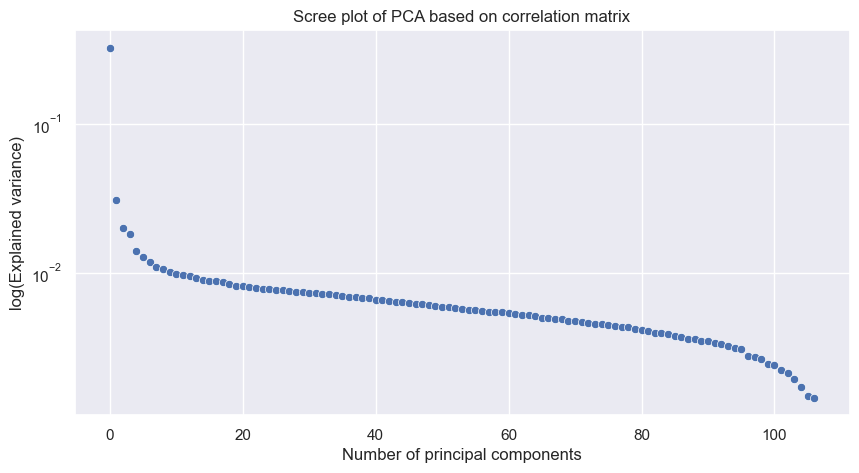

In [38]:
g = sns.scatterplot(
    data=pca_corr._explained_variance
)

g.set(xlabel='Number of principal components', ylabel='log(Explained variance)', title='Scree plot of PCA based on correlation matrix')

plt.yscale('log')
plt.show();

In [39]:
np.cumsum(pca_corr._explained_variance)

array([0.3246882 , 0.35573414, 0.37584951, 0.39402213, 0.4080429 ,
       0.42091247, 0.43267225, 0.44368473, 0.45437226, 0.46455094,
       0.47432858, 0.48405611, 0.49353145, 0.50275164, 0.51170214,
       0.52054671, 0.5293427 , 0.53800399, 0.5464682 , 0.55469713,
       0.56282686, 0.57089287, 0.57887101, 0.58669056, 0.59443248,
       0.60214347, 0.60977254, 0.61730551, 0.62479149, 0.63219863,
       0.63954963, 0.64682486, 0.65406615, 0.66122983, 0.66832868,
       0.67536174, 0.68228466, 0.68916422, 0.69598401, 0.70272128,
       0.70930281, 0.71583504, 0.7223058 , 0.72870776, 0.7350682 ,
       0.74131303, 0.74753803, 0.75369922, 0.75975471, 0.76577938,
       0.77169585, 0.77760304, 0.78341948, 0.78916427, 0.79483175,
       0.80044787, 0.80600542, 0.81150063, 0.81697251, 0.82242171,
       0.82781964, 0.83308853, 0.83834041, 0.84352183, 0.84865887,
       0.85367832, 0.85863583, 0.86356057, 0.86845189, 0.873233  ,
       0.87797635, 0.8826619 , 0.88729466, 0.89185404, 0.89637

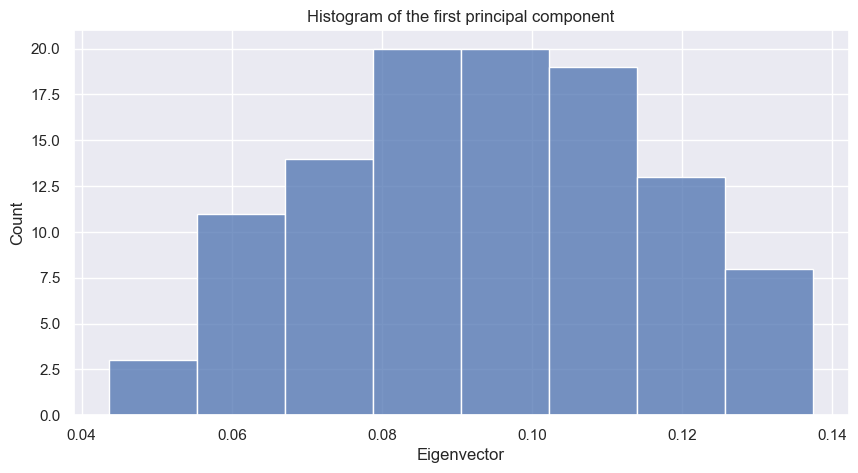

In [40]:
g = sns.histplot(
    pca_corr_loadings['PC1']
)

g.set(xlabel='Eigenvector', ylabel='Count', title='Histogram of the first principal component')

plt.show();

In [41]:
pca_corr_loadings.iloc[:, :5].corr()

,PC1,PC2,PC3,PC4,PC5
PC1,1.000000,-0.622624,-0.101775,0.208606,0.438094
PC2,-0.622624,1.000000,-0.003437,0.007045,0.014796
PC3,-0.101775,-0.003437,1.000000,0.001152,0.002419
PC4,0.208606,0.007045,0.001152,1.000000,-0.004957
PC5,0.438094,0.014796,0.002419,-0.004957,1.000000


In [42]:
def visualise_eigenvectors(data: pd.DataFrame, volatility_column: str) -> sns.PairGrid:
    g = sns.PairGrid(data.drop([volatility_column], axis=1))

    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot, hue=data[volatility_column])
    g.add_legend(title='Volatility')
    
    return g

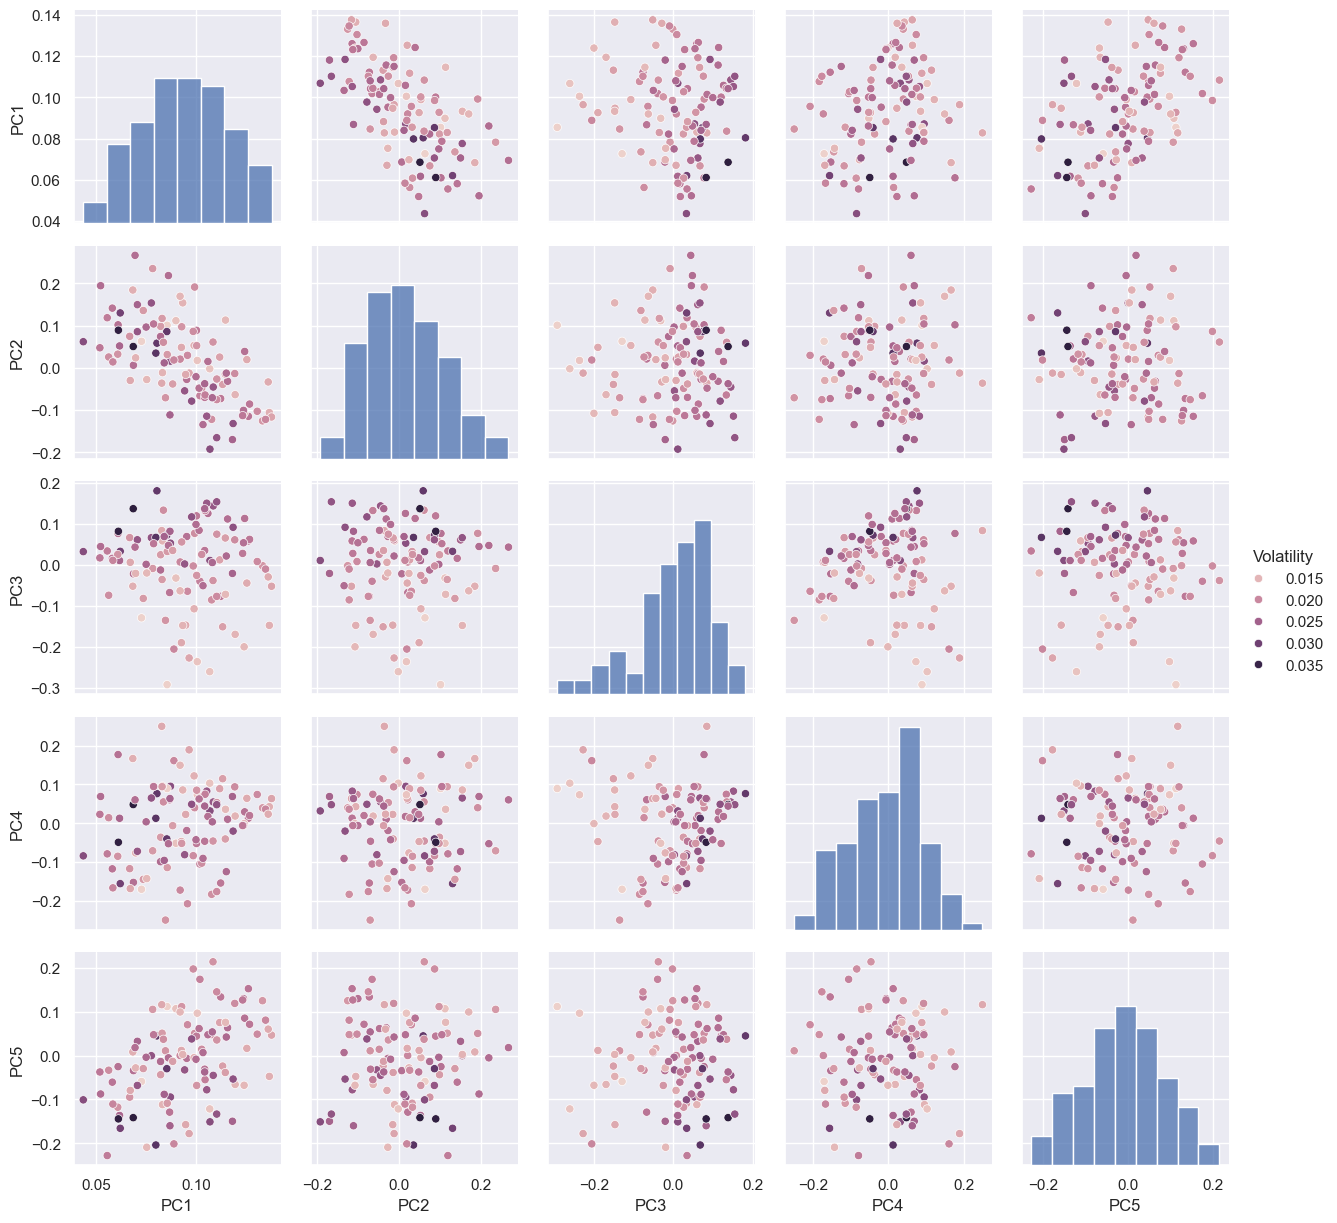

In [43]:
pca_corr_vol = pca_corr._components.iloc[:, :5].join(
    mean_var_df.set_index('symbol')['vol'] 
)

g = visualise_eigenvectors(pca_corr_vol, volatility_column='vol')
# plt.suptitle('Interactions between first five components of PCA')
plt.show();

In [44]:
pca_corr.transpose_loadings_sectors(cov_base=False, n_comp=10) 

,index,sector,component,loading
82,SANT.DE,,PC1,0.070584
59,KWS.DE,Basic Materials,PC1,0.069727
105,WCH.DE,Basic Materials,PC1,0.104161
38,FPE3.DE,Basic Materials,PC1,0.111638
47,HEI.DE,Basic Materials,PC1,0.130368
...,...,...,...,...
69,NEM.DE,Technology,PC9,0.029436
53,IFX.DE,Technology,PC9,0.033662
31,ECV.DE,Utilities,PC9,0.092943
80,RWE.DE,Utilities,PC9,0.058871


In [68]:
def visualise_eigenvectors_by_sector(data: pd.DataFrame, colours: list, order: list) -> sns.FacetGrid:
    
    g = sns.FacetGrid(
        data
        , col='component'
        , col_wrap=5
        , hue='sector'
        , palette=sns.color_palette("tab10")
        , height=3
        , aspect=1.5
    )
    
    g.map(
        sns.barplot
        , 'index'
        , 'loading'
        , errorbar=None
        # , hue_order=loadings_sectors.sector.unique().tolist()
        , hue_order=colours
        # , order=loadings_sectors.sort_values(by='sector')['index'].unique().tolist()
        , order=order 
    )
    
    g.set(
        xticks=[]
        , xlabel=None
        , ylabel='Loading'
    )
    
    g.add_legend()
    
    return g

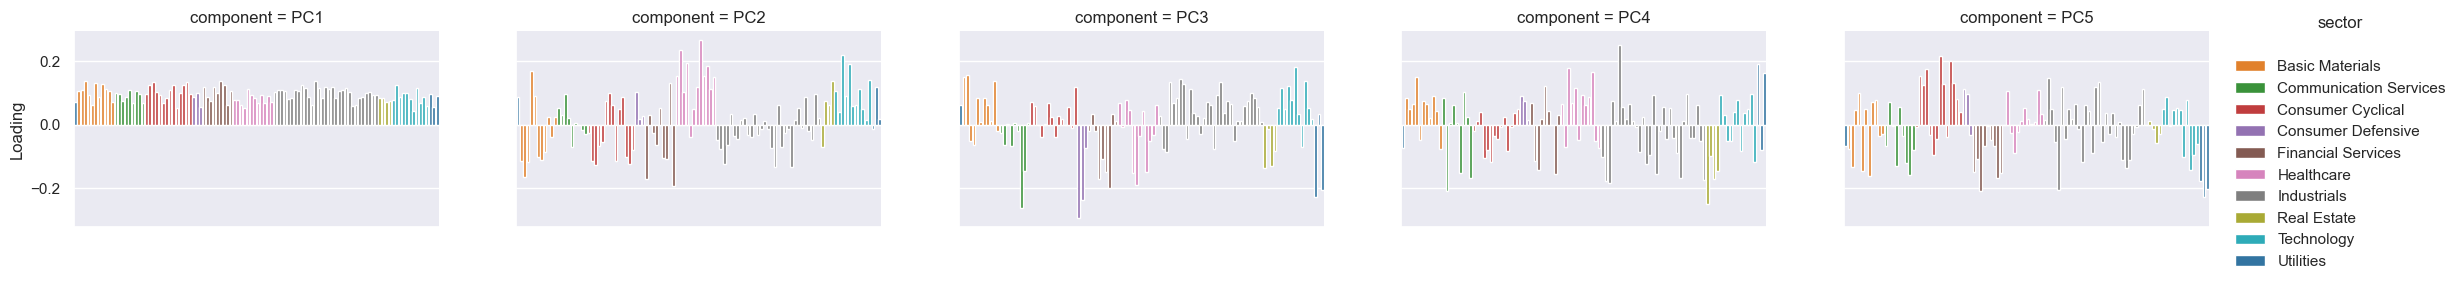

In [69]:
pca_corr_sectors = pca_corr.transpose_loadings_sectors(cov_base=False, n_comp=5)

visualise_eigenvectors_by_sector(
    data=pca_corr_sectors
    , colours=pca_corr_sectors.sector.unique().tolist()
    , order=pca_corr_sectors.sort_values(by='sector')['index'].unique().tolist()
);

# PCA on covariance matrix

In [73]:
pca_cov = dh.PCA(data=rts)

pca_cov.fit(cov_base=True, n_comp=rts.shape[1])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108
1U1.DE,0.090629,-0.010209,-0.035991,0.010307,-0.029732,0.164825,-0.095490,0.070530,-0.015989,-0.038202,...,0.050428,0.012733,-0.007479,-0.029653,0.024840,-0.005592,0.027499,-0.000318,0.002359,-0.006730
AAD.DE,0.087241,-0.016876,-0.066381,-0.040329,-0.077099,-0.000690,0.058301,-0.045707,-0.004530,0.001559,...,0.029004,0.006072,0.009376,-0.002560,0.000160,0.010391,-0.023847,0.009603,-0.000798,0.013109
ADS.DE,0.095439,-0.031868,-0.074305,0.016828,-0.011806,0.050536,0.070574,-0.049966,0.027590,0.009807,...,-0.042858,0.060620,-0.028206,-0.010470,-0.016652,-0.019399,0.033999,0.020636,-0.024627,0.008808
ADV.DE,0.115298,-0.024428,0.029597,0.028710,0.108266,0.102594,-0.217511,0.174402,-0.141196,0.142936,...,0.012453,-0.008708,0.028941,0.001534,-0.003987,0.004989,-0.016607,-0.001378,0.000539,0.003723
AFX.DE,0.066029,-0.154651,-0.095047,0.016396,0.001486,0.038575,0.027267,-0.010518,0.002273,0.006312,...,-0.011910,-0.042019,-0.012591,-0.009232,0.023633,-0.019914,-0.015120,-0.000250,0.007018,0.016752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOW3.DE,0.127465,0.107149,-0.032965,-0.007764,0.008239,-0.017897,0.066998,-0.066105,-0.017069,-0.001480,...,-0.096033,-0.081652,0.033039,0.588505,0.310414,0.224760,-0.011698,0.185676,-0.024388,-0.048484
WAC.DE,0.111751,0.020337,-0.020889,-0.013838,0.044349,-0.078621,0.066562,0.022600,-0.020223,-0.074455,...,0.032462,-0.021368,-0.012180,-0.001737,0.029044,0.008130,0.001803,-0.020582,0.024594,0.001501
WCH.DE,0.122488,0.018433,0.117915,0.041718,0.054480,-0.073803,0.010165,-0.008353,0.014125,-0.026897,...,-0.009647,0.017253,-0.017630,-0.010936,0.006621,0.013955,0.039175,0.006039,0.005947,0.012655
WSU.DE,0.056299,-0.015551,-0.059642,-0.041429,-0.062129,-0.056917,0.035959,-0.013090,-0.017929,-0.018756,...,0.006578,0.007012,-0.010283,0.002723,-0.007495,-0.000562,0.010536,-0.001347,-0.008761,-0.003422


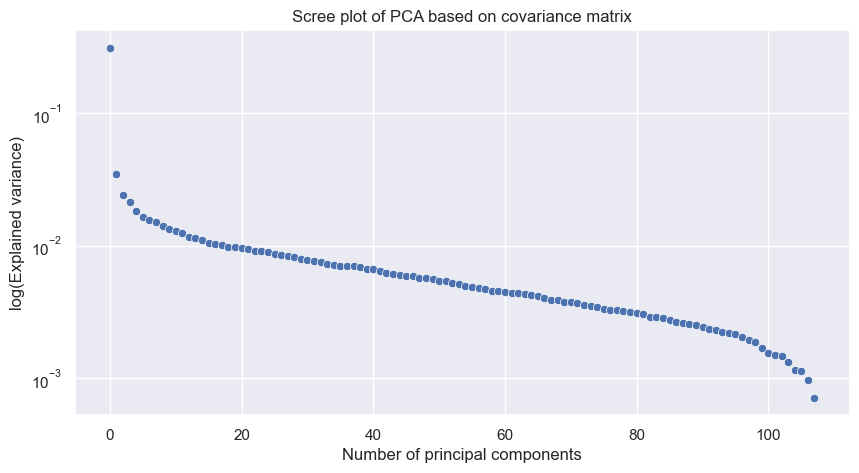

In [48]:
g = sns.scatterplot(
    data=pca_cov._explained_variance
)

g.set(xlabel='Number of principal components', ylabel='log(Explained variance)', title='Scree plot of PCA based on covariance matrix' )
plt.yscale('log')
plt.show();

In [49]:
np.cumsum(pca_cov._explained_variance)

array([0.31162898, 0.34627201, 0.37054354, 0.39186565, 0.41010308,
       0.42654792, 0.44221168, 0.45725538, 0.47145493, 0.48482035,
       0.49777872, 0.51025074, 0.5219838 , 0.53346056, 0.54443564,
       0.55488842, 0.56515041, 0.57522752, 0.58505387, 0.59480196,
       0.60442316, 0.61387423, 0.62305194, 0.63215049, 0.64113145,
       0.64986121, 0.65844128, 0.66679892, 0.6750537 , 0.68294349,
       0.69077208, 0.69843597, 0.70595425, 0.71326237, 0.72041845,
       0.7274951 , 0.73453535, 0.74152111, 0.74843588, 0.75515827,
       0.7617836 , 0.76825939, 0.77445119, 0.78058386, 0.78661012,
       0.79254705, 0.79843268, 0.80416127, 0.80982319, 0.81544601,
       0.82089868, 0.82630848, 0.83155663, 0.83669688, 0.84164216,
       0.84649369, 0.85129063, 0.85597557, 0.86056915, 0.86510064,
       0.86959177, 0.87402047, 0.87840678, 0.88271376, 0.88693693,
       0.89108882, 0.89508893, 0.89901939, 0.90289882, 0.90669207,
       0.91044814, 0.91415315, 0.9177116 , 0.92124904, 0.92467

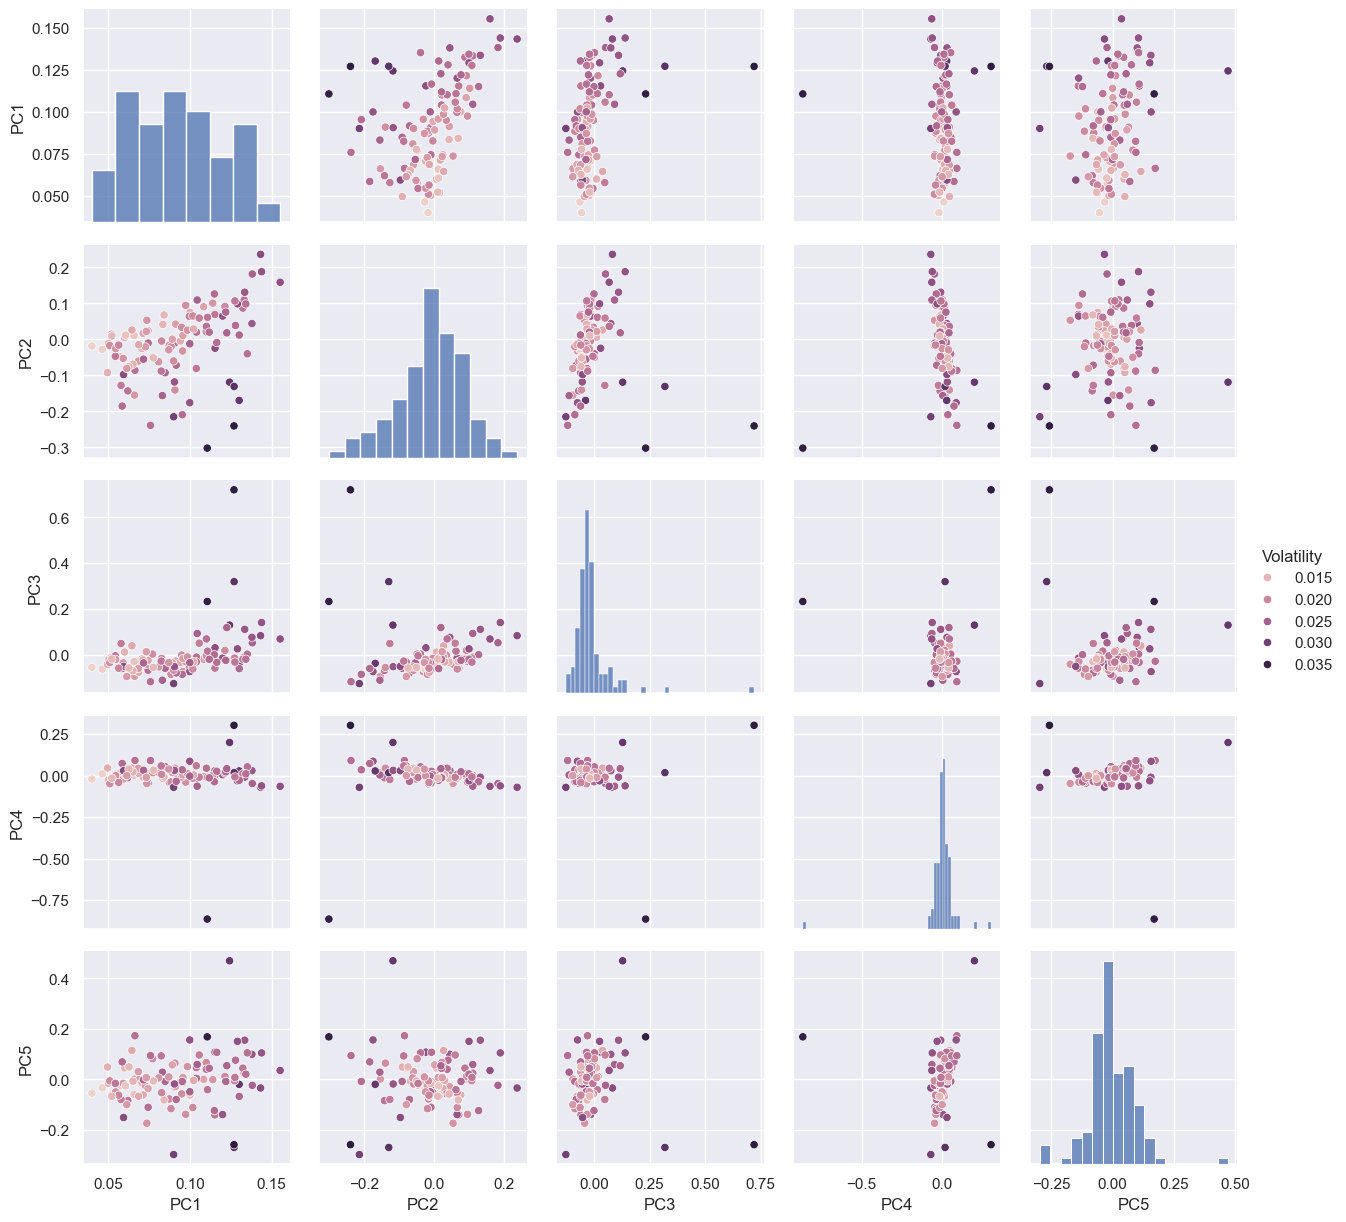

In [50]:
pca_cov_vol = pca_cov._components.iloc[:, :5].join(
    mean_var_df.set_index('symbol')['vol'] 
)

visualise_eigenvectors(pca_cov_vol, volatility_column='vol');

In [51]:
print(f"PC3; Skewness: {pca_cov._components['PC3'].skew():.3f}, kurtosis: {pca_cov._components['PC3'].kurtosis():.3f}")

PC3; Skewness: 4.803, kurtosis: 32.315


In [52]:
print(f"PC4; Skewness: {pca_cov._components['PC4'].skew():.3f}, kurtosis: {pca_cov._components['PC4'].kurtosis():.3f}")

PC4; Skewness: -6.455, kurtosis: 61.702


In [53]:
pca_cov._components.iloc[:, :5].corr() 

,PC1,PC2,PC3,PC4,PC5
PC1,1.000000,0.415769,0.400532,-0.039303,0.190149
PC2,0.415769,1.000000,-0.014553,0.001428,-0.006909
PC3,0.400532,-0.014553,1.000000,0.001376,-0.006656
PC4,-0.039303,0.001428,0.001376,1.000000,0.000653
PC5,0.190149,-0.006909,-0.006656,0.000653,1.000000


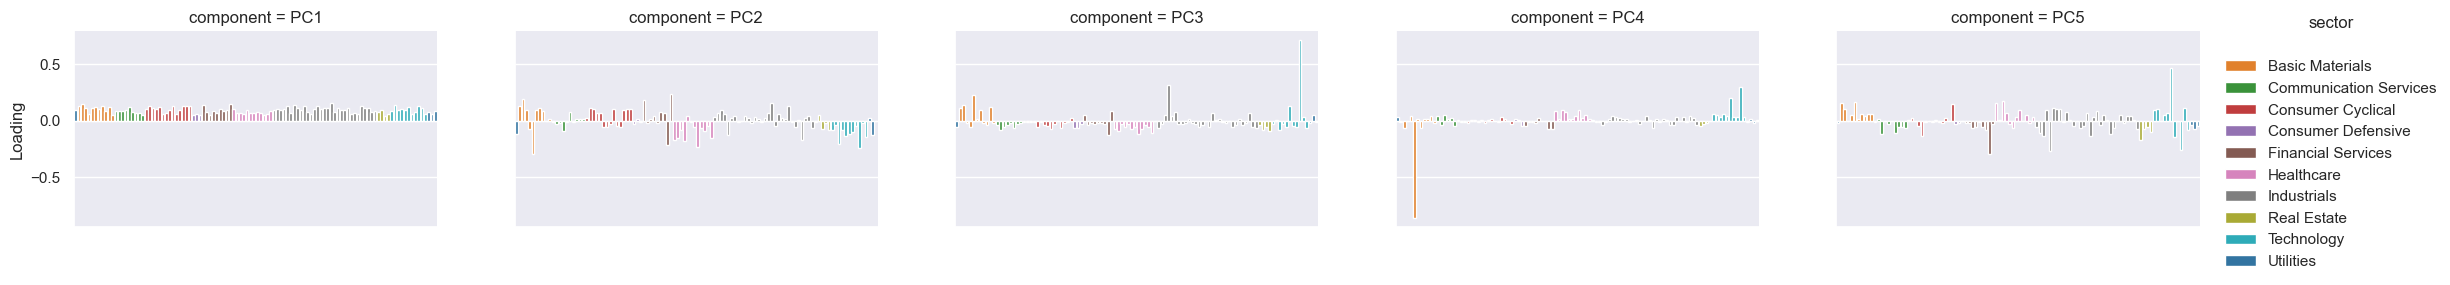

In [70]:
pca_cov_sectors = pca_cov.transpose_loadings_sectors(cov_base=True, n_comp=5)

visualise_eigenvectors_by_sector(
    data=pca_cov_sectors
    , colours=pca_cov_sectors.sector.unique().tolist()
    , order=pca_cov_sectors.sort_values(by='sector')['index'].unique().tolist()
);

# Comparing correlation vs. covariance matrices

In [74]:
pca_cov._explained_variance[:10] - pca_corr._explained_variance[:10] # Correlation matrix has more explanatory power in the first 4 components, then covariance matrix picks up more information from the data 

array([-0.01305922,  0.00359709,  0.00415616,  0.00314949,  0.00421665,
        0.00357528,  0.00390398,  0.00403121,  0.00351203,  0.00318674])

In [77]:
# corr_comp = pca_corr._components.iloc[:, :10]
# cov_comp = pca_cov._components.iloc[:, :10]
# diff_df = corr_comp - cov_comp
# 
# diff_df.head()

corr_comp = pca_corr.fit(cov_base=False, n_comp=10).join(
    mean_var_df.set_index('symbol')['vol'] 
)
cov_comp = pca_cov.fit(cov_base=True, n_comp=10)
# join(
#     mean_var_df.set_index('symbol')['vol'] 
# )

corr_comp

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,vol
1U1.DE,0.086676,0.021119,-0.067165,0.060552,-0.128948,0.361710,-0.072548,-0.101643,0.242585,-0.021774,0.022354
AAD.DE,0.091931,0.020796,0.007452,-0.172130,0.000427,0.023554,0.036603,0.018147,-0.036935,0.110309,0.020140
ADS.DE,0.108309,0.061199,-0.037907,-0.045728,0.214615,-0.059913,-0.016921,0.086322,-0.016380,-0.069537,0.018913
ADV.DE,0.087085,0.016111,0.053379,0.095221,-0.094375,0.145333,0.092870,-0.016992,0.021744,0.076105,0.027367
AFX.DE,0.078213,0.235176,-0.008406,-0.070873,0.105942,-0.088984,0.038599,0.027803,-0.122543,-0.017851,0.018151
...,...,...,...,...,...,...,...,...,...,...,...
VOW3.DE,0.123091,-0.113011,0.028386,-0.005948,0.127349,-0.157837,-0.176434,-0.066697,0.226161,0.113194,0.021856
WAC.DE,0.099824,-0.020936,0.099103,-0.042472,-0.008057,0.022146,-0.121243,0.010507,-0.077014,0.014590,0.023357
WCH.DE,0.104161,-0.037541,0.137608,0.044241,-0.037100,-0.106020,-0.001212,-0.052804,0.045168,-0.129516,0.024235
WSU.DE,0.058366,0.014129,0.011425,-0.166309,-0.110500,0.084268,-0.153405,-0.088618,-0.170752,0.011790,0.020433


In [76]:
corr_cov_vol = (
    pca_corr.fit(cov_base=False, n_comp=10)
        .join(
            pca_cov.fit(cov_base=True, n_comp=10)
            , lsuffix='_corr'
            , rsuffix='_cov'
        ).join(
            mean_var_df.set_index('symbol')['vol'] 
        )
    )

corr_cov_vol

,PC1_corr,PC2_corr,PC3_corr,PC4_corr,PC5_corr,PC6_corr,PC7_corr,PC8_corr,PC9_corr,PC10_corr,...,PC2_cov,PC3_cov,PC4_cov,PC5_cov,PC6_cov,PC7_cov,PC8_cov,PC9_cov,PC10_cov,vol
1U1.DE,0.086676,0.021119,-0.067165,0.060552,-0.128948,0.361710,-0.072548,-0.101643,0.242585,-0.021774,...,-0.010209,-0.035991,0.010307,-0.029732,0.164825,-0.095490,0.070530,-0.015989,-0.038202,0.022354
AAD.DE,0.091931,0.020796,0.007452,-0.172130,0.000427,0.023554,0.036603,0.018147,-0.036935,0.110309,...,-0.016876,-0.066381,-0.040329,-0.077099,-0.000690,0.058301,-0.045707,-0.004530,0.001559,0.020140
ADS.DE,0.108309,0.061199,-0.037907,-0.045728,0.214615,-0.059913,-0.016921,0.086322,-0.016380,-0.069537,...,-0.031868,-0.074305,0.016828,-0.011806,0.050536,0.070574,-0.049966,0.027590,0.009807,0.018913
ADV.DE,0.087085,0.016111,0.053379,0.095221,-0.094375,0.145333,0.092870,-0.016992,0.021744,0.076105,...,-0.024428,0.029597,0.028710,0.108266,0.102594,-0.217511,0.174402,-0.141196,0.142936,0.027367
AFX.DE,0.078213,0.235176,-0.008406,-0.070873,0.105942,-0.088984,0.038599,0.027803,-0.122543,-0.017851,...,-0.154651,-0.095047,0.016396,0.001486,0.038575,0.027267,-0.010518,0.002273,0.006312,0.018151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VOW3.DE,0.123091,-0.113011,0.028386,-0.005948,0.127349,-0.157837,-0.176434,-0.066697,0.226161,0.113194,...,0.107149,-0.032965,-0.007764,0.008239,-0.017897,0.066998,-0.066105,-0.017069,-0.001480,0.021856
WAC.DE,0.099824,-0.020936,0.099103,-0.042472,-0.008057,0.022146,-0.121243,0.010507,-0.077014,0.014590,...,0.020337,-0.020889,-0.013838,0.044349,-0.078621,0.066562,0.022600,-0.020223,-0.074455,0.023357
WCH.DE,0.104161,-0.037541,0.137608,0.044241,-0.037100,-0.106020,-0.001212,-0.052804,0.045168,-0.129516,...,0.018433,0.117915,0.041718,0.054480,-0.073803,0.010165,-0.008353,0.014125,-0.026897,0.024235
WSU.DE,0.058366,0.014129,0.011425,-0.166309,-0.110500,0.084268,-0.153405,-0.088618,-0.170752,0.011790,...,-0.015551,-0.059642,-0.041429,-0.062129,-0.056917,0.035959,-0.013090,-0.017929,-0.018756,0.020433


In [57]:
# X = sm.add_constant(corr_comp['vol'])
y = corr_comp['vol']

for i in range(10):
    # y = corr_comp.iloc[:, i]
    X = sm.add_constant(corr_comp.iloc[:, i]) 
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    print(f'{X.columns}: {results.rsquared:.6f}, \n')
    # print(results.summary())
    # print('----------------')

Index(['const', 'PC1'], dtype='object'): 0.046009, 

Index(['const', 'PC2'], dtype='object'): 0.002438, 

Index(['const', 'PC3'], dtype='object'): 0.401722, 

Index(['const', 'PC4'], dtype='object'): 0.005018, 

Index(['const', 'PC5'], dtype='object'): 0.070118, 

Index(['const', 'PC6'], dtype='object'): 0.024742, 

Index(['const', 'PC7'], dtype='object'): 0.041768, 

Index(['const', 'PC8'], dtype='object'): 0.013029, 

Index(['const', 'PC9'], dtype='object'): 0.012185, 

Index(['const', 'PC10'], dtype='object'): 0.001379, 


In [58]:
# X = sm.add_constant(corr_comp['vol'])
y = cov_comp['vol']

for i in range(10):
    # y = corr_comp.iloc[:, i]
    X = sm.add_constant(cov_comp.iloc[:, i]) 
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    print(f'{X.columns}: {results.rsquared:.6f}, \n')
    # print(results.summary())
    # print('----------------')

Index(['const', 'PC1'], dtype='object'): 0.372382, 

Index(['const', 'PC2'], dtype='object'): 0.049225, 

Index(['const', 'PC3'], dtype='object'): 0.276531, 

Index(['const', 'PC4'], dtype='object'): 0.020559, 

Index(['const', 'PC5'], dtype='object'): 0.009372, 

Index(['const', 'PC6'], dtype='object'): 0.171549, 

Index(['const', 'PC7'], dtype='object'): 0.000001, 

Index(['const', 'PC8'], dtype='object'): 0.000501, 

Index(['const', 'PC9'], dtype='object'): 0.001829, 

Index(['const', 'PC10'], dtype='object'): 0.000958, 


In [81]:
for col in cov_comp.columns:
    y = cov_comp[col]
    X = sm.add_constant(corr_comp[[col, 'vol']])
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    print(results.summary())
    print('----------------')

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1729.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           4.43e-81
Time:                        12:45:08   Log-Likelihood:                 426.04
No. Observations:                 108   AIC:                            -846.1
Df Residuals:                     105   BIC:                            -838.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0947      0.003    -29.469      0.0